## Optimizing Personalized Treatment Strategies for Acute Hypotensive Patients

Description of Environment:

1. State Space: The state space represents the current condition of the patient which includes:
    * Vital signs: Heart rate, systolic and diastolic blood pressure, respiratory rate, oxygen saturation, etc.
    * Biochemical markers: Blood pH, lactate levels, creatinine, and other lab results that provide insights into organ function
    * Demographics and medical history: Patient age, gender, weight, comorbidities (e.g. diabetes, renal failure)
    * Previous treatment: Prior medication dosages and fluid levels administered during the current ICU stay. 

2. Action Space: Discrete treatment actions that a clinician could take to manage acute hypotension in ICU patients. This may include: 
    * Fluid Administration (e.g. low, medium, high dosage)
    * Vasopressor administration (e.g. low, medium, high dosage)
    * No intervention (wait and observe)
    Each of these actions will have an immediate impact on the patient’s state (e.g. vital signs, biochemical markers), making it crucial to optimize the sequence of actions based on the patient’s evolving condition. 

3. Reward Function: The reward at time step $t$ is dependent on the Mean Arterial Pressure $MAP_t$ and is given by:

$$\text{reward}_t = \begin{cases}
0 & \text{if MAP$_t > 65$} \\
\frac{-0.05(65-\text{MAP}_t)}{5} & \text{if $60 < \text{MAP}_t \le 65$} \\
\frac{-0.1(60-\text{MAP}_t)}{5}-0.05 & \text{if $55 < \text{MAP}_t \le 60$} \\
\frac{-0.85(55-\text{MAP}_t)}{15}-0.15 & \text{if $\text{MAP}_t \le 55$} \\
\end{cases}$$

But the reward value is also dictated, and overwritten by the urine output at time step t:

$$\text{reward}_t = 0 \text{ if urine}_t >30\text{ and MAP}_t >55$$

The objective of the project is to develop an AI-based decision support system that assists clinicians in personalizing treatment strategies for acute hypotension. We will :

* Learn to recommend optimal treatments based on patient-specific data, adapting in real-time to their evolving condition.
* Compare the performance of model-free approaches with model-based techniques to identify which provides more reliable and clinically relevant reccomendations
* Use off-policy evaluation methods such as weighted importance sampling and bootstrapping to ensure safe and effective policies without real-world deployment. 


### Exploration

In [ ]:
%matplotlib inline
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('Data/C001_FakeHypotension.csv')
print(f'Number of unique patients: {df["PatientID"].nunique()}')
df.head()

Number of unique patients: 3910


,Unnamed: 0,MAP,diastolic_bp,systolic_bp,urine,ALT,AST,PO2,lactic_acid,serum_creatinine,...,GCS_total,urine_m,ALT_AST_m,FiO2_m,GCS_total_m,PO2_m,lactic_acid_m,serum_creatinine_m,PatientID,Timepoints
0,0,67.964940,56.709198,144.578430,241.00052,24.226444,23.811718,83.46306,1.477299,0.893153,...,15,0,0,0,1,0,0,0,0,0
1,1,63.603493,53.635162,143.283780,230.52171,23.933348,30.188170,120.01681,1.733099,0.862924,...,15,0,0,0,0,0,0,0,0,1
2,2,65.750670,56.904236,143.534000,217.76741,21.803823,26.318861,84.16420,1.375228,0.819521,...,15,0,0,0,0,0,0,0,0,2
3,3,44.684580,41.952940,117.236534,291.90466,33.613720,24.136852,102.35325,1.252799,0.754315,...,15,1,0,0,0,0,0,0,0,3
4,4,61.486233,63.960106,111.537060,435.26230,45.407272,23.192320,63.73771,1.845126,1.155209,...,15,0,0,0,1,0,0,0,0,4


---

### Following HealthGym Tutorial

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cross_decomposition import PLSCanonical
from sklearn.cluster import KMeans

In [ ]:
# divide state and action pairs
df = pd.read_csv('Data/C001_FakeHypotension.csv')
print(f'Number of unique patients: {df["PatientID"].nunique()}')

num_patients = df['PatientID'].nunique()

actions = ['fluid_boluses', 'vasopressors']
df_state = df.drop(columns=actions)
df_action = df[actions]

Number of unique patients: 3910


In [ ]:
# cross decomposition to reduce the dimensionality of the state space to 5 variables
df_action = pd.get_dummies(df_action, prefix=['fluid_boluses'], columns=['fluid_boluses'])
df_action = pd.get_dummies(df_action, prefix=['vasopressors'], columns=['vasopressors'])

# partial least squares regression
plsca = PLSCanonical(n_components=5)
X = df_state.astype(float).values
Y = df_action.astype(float).values
X_norm = (X-X.mean(axis=0))/(X.std(axis=0))
Y_norm = (Y-Y.mean(axis=0))/(Y.std(axis=0))
X_canonical, Y_canonical = plsca.fit_transform(X_norm, Y_norm)

In [ ]:
# k-means clustering to assign each patient to one of the 100 clusters
# An appropriate number of clusters can be determined e.g. by looking at improvements in the Davies Boulding score.
num_states = 100
km = KMeans(n_clusters = num_states, n_init = 10, random_state = 123, verbose = True)
state_number = km.fit(X_canonical).labels_

Initialization complete
Iteration 0, inertia 263047.1816022791.
Iteration 1, inertia 244652.3651782734.
Iteration 2, inertia 239230.44776363095.
Iteration 3, inertia 236391.33677104072.
Iteration 4, inertia 234571.78878517443.
Iteration 5, inertia 233267.22236344803.
Iteration 6, inertia 232262.3610890707.
Iteration 7, inertia 231510.3251850554.
Iteration 8, inertia 230893.2082341767.
Iteration 9, inertia 230360.94227911875.
Iteration 10, inertia 229882.16745871247.
Iteration 11, inertia 229448.88778009047.
Iteration 12, inertia 229070.12246020066.
Iteration 13, inertia 228741.20487225798.
Iteration 14, inertia 228459.73134332616.
Iteration 15, inertia 228208.59944884045.
Iteration 16, inertia 228003.12561647824.
Iteration 17, inertia 227817.86696566181.
Iteration 18, inertia 227660.7686908482.
Iteration 19, inertia 227519.99931017339.
Iteration 20, inertia 227383.14596302249.
Iteration 21, inertia 227250.48991856596.
Iteration 22, inertia 227123.20462053694.
Iteration 23, inertia 2270

Before implementing the actual reinforcement learning algorithm, let’s add a few useful variables to the dataframe. ‘hour’ represents the hour (between 0 and 47) in which measurements were taken, ‘action_number’ is a number between 0 and 15 indicating the action taken (every combination of four levels of administered fluid boluses and four levels of vasopressors), ‘state_number’ indicates the cluster associated with the state at time t, and ‘state_number_tp1’ indicates the cluster associated with the state at time t+1.

In [ ]:
fluid_boluses_mapping = {v:i for i,v in enumerate(sorted(df['fluid_boluses'].unique()))}
vasopressors_mapping = {v:i for i,v in enumerate(sorted(df['vasopressors'].unique()))}

df['hour'] = np.tile(range(48), num_patients)
df['fluid_boluses'] = df['fluid_boluses'].map(fluid_boluses_mapping)
df['vasopressors'] = df['vasopressors'].map(vasopressors_mapping)
df['action_number'] = 4 * df['fluid_boluses'] + df['vasopressors']
df['state_number'] = state_number
df['state_number_tp1'] = df['state_number'].shift(-1)

In [ ]:
def reward_function(row):
    if row.MAP > 65: # 0 at >65
        reward = 0
    elif row.MAP > 60: # -0.05 at 60 and 0 at 65
        reward = -0.05 * (65 - row.MAP) / 5
    elif row.MAP > 55: # -0.15 at 55 and -0.05 at 60
        reward = -0.10 * (60 - row.MAP) / 5 - 0.05
    else: # -1 at 40 and -0.15 at 55
        reward = -0.85 * (55 - row.MAP) / 15 - 0.15
    if row.urine > 30 and row.MAP > 55:
        reward = 0
    return reward

df['reward'] = df.apply(lambda row: reward_function(row), axis=1)
# shift one up so that reward is in the same row of action
df['reward'] = df['reward'].shift(-1)

In [ ]:
# ignore last hour since we don't observe the reward of action
df = df[df['hour'] < 47]
df['state_number_tp1'] = df['state_number_tp1'].astype(int)

A simple algorithm for offline reinforcement learning (where we are given a fixed batch of data and can’t interact with the environment to collect new data) is Batch-Constrained Q-learning (BCQL). [5] It determines an optimal policy in a way similar to standard Q-learning [6], except that the max over action values in the next state is taken only over actions that have actually been observed in the data.

In [ ]:
# q-learning
Q = np.full((100, 16), np.nan, dtype='float') # 100 states, 16 actions
# Set to 0 if state-action combination has actually been observed in the data
for index, row in df.iterrows():
    state_number = int(row['state_number'])
    action_number = int(row['action_number'])
    Q[state_number, action_number] = 0

num_iterations = 100
step_size = 0.1
diff_tracker = np.zeros((num_iterations, 1))
for Q_iter in range(num_iterations):
    Q_old = Q.copy()
    for index, row in df.iterrows():
        # Discount factor gamma = 1
        state_number = int(row['state_number'])
        action_number = int(row['action_number'])
        state_number_tp1 = int(row['state_number_tp1'])
        Q[state_number, action_number] += step_size * (row['reward'] + np.nanmax(Q[state_number_tp1, :]) - Q[state_number, action_number])
    diff_tracker[Q_iter] = np.nanmean(np.abs(Q-Q_old))
    print([Q_iter, diff_tracker[Q_iter]])

[0, array([0.04382216])]
[1, array([0.00872146])]
[2, array([0.00511726])]
[3, array([0.00354669])]
[4, array([0.00264911])]
[5, array([0.00207038])]
[6, array([0.00166891])]
[7, array([0.00137577])]
[8, array([0.0011532])]
[9, array([0.00097898])]
[10, array([0.00083928])]
[11, array([0.00072509])]
[12, array([0.00063029])]
[13, array([0.00055061])]
[14, array([0.00048297])]
[15, array([0.00042506])]
[16, array([0.00037516])]
[17, array([0.00033191])]
[18, array([0.00029424])]
[19, array([0.0002613])]
[20, array([0.00023241])]
[21, array([0.00020698])]
[22, array([0.00018455])]
[23, array([0.00016471])]
[24, array([0.00014714])]
[25, array([0.00013155])]
[26, array([0.00011769])]
[27, array([0.00010536])]
[28, array([9.43701088e-05])]
[29, array([8.45701304e-05])]
[30, array([7.58212875e-05])]
[31, array([6.80043245e-05])]
[32, array([6.10147812e-05])]
[33, array([5.47609135e-05])]
[34, array([4.91619527e-05])]
[35, array([4.41466395e-05])]
[36, array([3.96519822e-05])]
[37, array([3.

The expected value of the RL policy can now be compared to the value of the original clinical policy or a random policy. The expected value of the RL policy is higher than for the other policies.

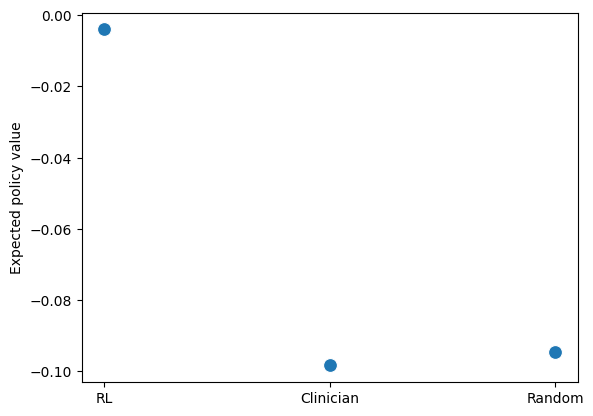

In [ ]:
# evaluate
Q_RL = 0
Q_clinician = 0
Q_random =0 

for index, row in df.iterrows():
    if row['hour'] == 0:
        Q_RL += np.nanmax(Q[int(row['state_number']), :])
        Q_clinician += Q[int(row['state_number']), int(row['action_number'])]
        # random policy
        h = Q[int(row['state_number']), :]
        h = h[~np.isnan(h)]
        Q_random += h[np.random.choice(h.shape[0], 1)][0]
Q_RL = Q_RL / num_patients
Q_clinician = Q_clinician / num_patients
Q_random = Q_random / num_patients

sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], markers='s', s=100)
plt.ylabel('Expected policy value')
plt.show()

/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_23522/469497237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_RF['action_number'] = 0
/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_23522/469497237.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_RF['agent'] = 'RF'
/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_23522/469497237.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

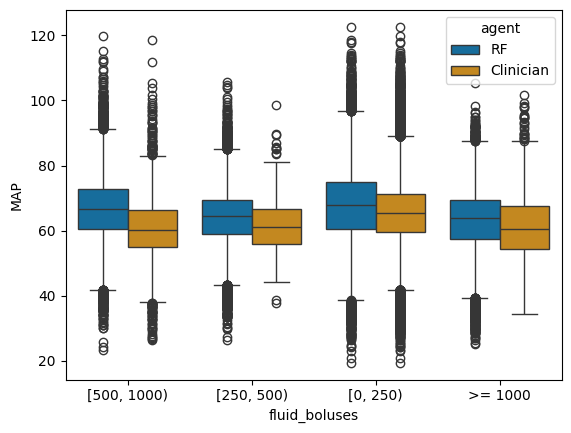

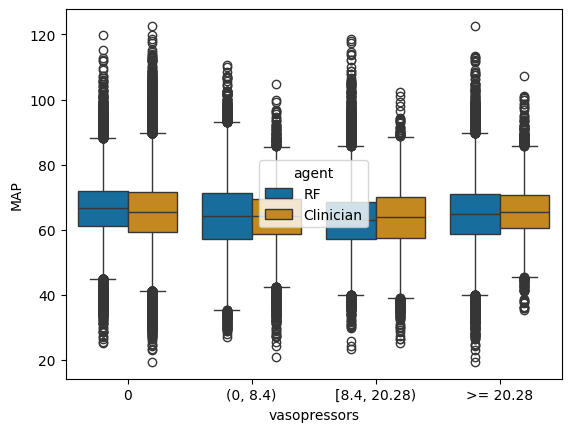

In [ ]:
df_boxplot_RF = df[['MAP']]
df_boxplot_RF['action_number'] = 0
for index, row in df.iterrows():
    df_boxplot_RF.at[index, 'action_number'] = np.nanargmax(Q[int(row['state_number']), :])

df_boxplot_RF['agent'] = 'RF'
df_boxplot_clinician = df[['MAP', 'action_number']]
df_boxplot_clinician['agent'] = 'Clinician'
df_boxplot = pd.concat([df_boxplot_RF, df_boxplot_clinician], ignore_index=True, sort=False)

fluid_boluses_dict = {
    **dict.fromkeys([0, 1, 2, 3], '[0, 250)'),
    **dict.fromkeys([4, 5, 6, 7], '[250, 500)'),
    **dict.fromkeys([8, 9, 10, 11], '[500, 1000)'),
    **dict.fromkeys([12, 13, 14, 15], '>= 1000')
}
vasopressors_dict = {
    **dict.fromkeys([0, 4, 8, 12], '0'),
    **dict.fromkeys([1, 5, 9, 13], '(0, 8.4)'),
    **dict.fromkeys([2, 6, 10, 14], '[8.4, 20.28)'),
    **dict.fromkeys([3, 7, 11, 15], '>= 20.28')
}
df_boxplot['fluid_boluses'] = df_boxplot['action_number'].replace(fluid_boluses_dict)
df_boxplot['vasopressors'] = df_boxplot['action_number'].replace(vasopressors_dict)

sns.boxplot(y='MAP', x='fluid_boluses', data=df_boxplot, palette="colorblind", hue='agent')
plt.show()
sns.boxplot(y='MAP', x='vasopressors', data=df_boxplot, palette="colorblind", hue='agent', order=['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28'])
plt.show()

---

### Discrete Batch Constrained Q-Learning

**Batch Constrained Q-Learning** in the original paper (for continuous action space):

- VAE: Learns to model the action distribution from the dataset, providing a way to generate reasonable actions from states.
- Perturbation Network: Adjusts actions slightly to explore small variations around the data distribution.
- Clipped Double Q-Learning: Uses the minimum of two Q-values to avoid overestimating action values.
- Constrained Action Selection: Keeps actions close to those in the batch data to avoid extrapolation errors.

In discrete-batch constrained deep q-learning [(link to paper)](https://www.google.com/url?sa=i&url=https%3A%2F%2Farxiv.org%2Fpdf%2F1910.01708&psig=AOvVaw1oXk9Lxn-vsGx8ko-gx9TH&ust=1729480237769000&source=images&cd=vfe&opi=89978449&ved=0CAQQn5wMahcKEwiQi8-N_puJAxUAAAAAHQAAAAAQBA), we can compute the probabilities of every action and utilize some threshold to eliminate actions. To adaptively adjust this threshold, we scale it by the maximum probability from the generative model over all actions, to only allow actions whose relative probability is above some threshold. This results in an algorithm comparable to DQN [Mnih et al., 2015] where the policy is defined by a constrained argmax. The Q-network is trained by swapping the max operation with actions selected by the policy. 

Another source for consideration: [link](https://danieltakeshi.github.io/2020/06/28/offline-rl/)

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import deque
from sklearn.cross_decomposition import PLSCanonical

In [ ]:
# hyperparameters
state_dim = 5
action_dim = 16
hidden_dim = 128
gamma = 0.99
tau = 0.005

class ReplayBuffer:
    def __init__(self, max_size=1000000, batch_size=32):
        self.buffer = deque(maxlen=max_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self):
        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        # convert to tensors
        return (
            torch.FloatTensor(states),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(next_states),
            torch.FloatTensor(dones)
        )

    def __len__(self):
        return len(self.buffer)

In [ ]:
# behavior cloning model - outputs a distribution over the 16 discrete actions
class BehaviorCloning(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(BehaviorCloning, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim), # one output per action
        )

    def forward(self, state):
        return self.network(state)
    
class DiscreteDQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(DiscreteDQN, self).__init__()
        self.q = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)  # One output per action
        )

    def forward(self, state):
        return self.q(state)
    

# BCQ for discrete actions
class BCQDiscrete:
    def __init__(self, state_dim, action_dim, hidden_dim=128, gamma=0.99, tau=0.01, bcq_threshold=0.3, device="mps"):
        self.tau = tau
        self.gamma = gamma
        self.threshold = bcq_threshold
        self.device = device

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_network = DiscreteDQN(state_dim, action_dim, hidden_dim).to(device)
        self.target_q_network = DiscreteDQN(state_dim, action_dim, hidden_dim).to(device)
        self.behavior_model = BehaviorCloning(state_dim, action_dim, hidden_dim).to(device)

        self.q_optimizer = optim.Adam(self.q_network.parameters(), lr=5e-5)
        self.behavior_optimizer = optim.Adam(self.behavior_model.parameters(), lr=1e-4)

        # copy weights to target model
        self.target_q_network.load_state_dict(self.q_network.state_dict())
        self.q_losses = []
        self.behavior_losses = []

    def select_action(self, states):
        # select action according to policy
        with torch.no_grad():
            # get q values from q-network
            q_values = self.target_q_network(states)

            # calculate action probabilities from behavior model
            behavior_logits = self.behavior_model(states)
            action_probs = F.softmax(behavior_logits, dim=1)

            # identify unlikely actions based on threshold
            max_action_prob = action_probs.max(dim=1, keepdim=True)[0]
            imt = (action_probs / max_action_prob > self.threshold).float()

            # mask unlikely actions
            masked_q_values = imt * q_values + (1. - imt) * -1e8
            next_actions = masked_q_values.argmax(dim=1)
            
            return next_actions
        
              
    def train(self, replay_buffer, num_steps=100000):
        # we run a behavior model first 
        # (so that the first few iterations of optimization are not based on totally incorrect values)
        # run for 30000 steps first 
        print(f'Training behavior model...')
        for iteration in range(30000):
            # sample from replay buffer
            states, actions, rewards, next_states, dones = replay_buffer.sample()
            states, actions, rewards, next_states, dones = states.to(self.device), actions.to(self.device), rewards.to(self.device), next_states.to(self.device), dones.to(self.device)

            # behavior cloning (cross-entropy loss with one-hot actions)
            behavior_logits = self.behavior_model(states)
            behavior_loss = nn.CrossEntropyLoss()(behavior_logits, actions)

            # update behavior model
            self.behavior_optimizer.zero_grad()
            behavior_loss.backward()
            self.behavior_optimizer.step()

            self.behavior_losses.append(behavior_loss.item())

            if (iteration>0) and (iteration % 1000==0):
                avg_bc_loss = sum(self.behavior_losses[-1000:]) / 1000
                print(f'[Step {iteration}/30000] Avg Loss: {avg_bc_loss}')

        print(f'\nTraining q-network...')
        for iteration in range(num_steps):
            # sample from replay buffer
            states, actions, rewards, next_states, dones = replay_buffer.sample()
            states, actions, rewards, next_states, dones = states.to(self.device), actions.to(self.device), rewards.to(self.device), next_states.to(self.device), dones.to(self.device)

            # select next action using behavior model
            next_actions = self.select_action(next_states)

            # compute q-targets
            with torch.no_grad():
                q_values_next = self.target_q_network(next_states)
                q_values_next = q_values_next.gather(1, next_actions.unsqueeze(1)).squeeze(1)
                q_targets = rewards + (self.gamma * (1 - dones) * q_values_next)

            # compute current q estimates
            q_current = self.q_network(states)
            q_current = q_current.gather(1, actions.unsqueeze(1)).squeeze(1)

            # q loss
            q_loss = F.smooth_l1_loss(q_current, q_targets) 

            # update q-network
            self.q_optimizer.zero_grad()
            q_loss.backward()
            self.q_optimizer.step()

            # soft update for target q
            for param, target_param in zip(self.q_network.parameters(), self.target_q_network.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
    
            # store loss
            self.q_losses.append(q_loss.item())

            if (iteration > 0) and (iteration % 1000 == 0):
                avg_q_loss = sum(self.q_losses[-1000:]) / 1000
                print(f'[Step {iteration}/{num_steps}] Avg Q-Loss: {avg_q_loss}')

In [ ]:
# load data
df = pd.read_csv('Data/C001_FakeHypotension.csv')
print(f'Number of unique patients: {df["PatientID"].nunique()}')

num_patients = df['PatientID'].nunique()
actions = ['fluid_boluses', 'vasopressors']
df_state = df.drop(columns=actions)
df_action = df[actions]

Number of unique patients: 3910


In [ ]:
# cross decomposition to reduce the dimensionality of the state space to 5 variables
df_action = pd.get_dummies(df_action, prefix=['fluid_boluses'], columns=['fluid_boluses'])
df_action = pd.get_dummies(df_action, prefix=['vasopressors'], columns=['vasopressors'])

# partial least squares regression
plsca = PLSCanonical(n_components=5)
X = df_state.astype(float).values
Y = df_action.astype(float).values
X_norm = (X-X.mean(axis=0))/(X.std(axis=0))
Y_norm = (Y-Y.mean(axis=0))/(Y.std(axis=0))
X_canonical, Y_canonical = plsca.fit_transform(X_norm, Y_norm)

In [ ]:
fluid_boluses_mapping = {v:i for i,v in enumerate(sorted(df['fluid_boluses'].unique()))}
vasopressors_mapping = {v:i for i,v in enumerate(sorted(df['vasopressors'].unique()))}

df['fluid_boluses'] = df['fluid_boluses'].map(fluid_boluses_mapping)
df['vasopressors'] = df['vasopressors'].map(vasopressors_mapping)
df['action_number'] = 4 * df['fluid_boluses'] + df['vasopressors']

def reward_function(row):
    if row.MAP > 65: # 0 at >65
        reward = 0
    elif row.MAP > 60: # -0.05 at 60 and 0 at 65
        reward = -0.05 * (65 - row.MAP) / 5
    elif row.MAP > 55: # -0.15 at 55 and -0.05 at 60
        reward = -0.10 * (60 - row.MAP) / 5 - 0.05
    else: # -1 at 40 and -0.15 at 55
        reward = -0.85 * (55 - row.MAP) / 15 - 0.15
    if row.urine > 30 and row.MAP > 55:
        reward = 0
    return reward

df['reward'] = df.apply(lambda row: reward_function(row), axis=1)
# shift one up so that reward is in the same row of action
df['reward'] = df['reward'].shift(-1)

In [ ]:
df.rename(columns={
    "action_number": "action",
    "PatientID": "id",
    "Timepoints": "hour"
}, inplace=True)

In [ ]:
# load data into buffer
buffer = ReplayBuffer()

for index, row in df.iterrows():
    # ignore last hour since we don't observe the reward of next state
    if row['hour'] == 47:
        continue
    done = 0
    next_state = np.array(X_canonical[index+1])
    reward = row['reward']
    state = np.array(X_canonical[index])
    action = int(row['action'])
    # add transition to buffer
    buffer.add(state, action, reward, next_state, done)

In [ ]:
# train bcq
BCQDiscreteAgent = BCQDiscrete(
    state_dim=5,
    action_dim=16,
    hidden_dim=128
)

BCQDiscreteAgent.train(buffer, num_steps=80000)

Training behavior model...
[Step 1000/30000] Avg Loss: 0.9587355200648308
[Step 2000/30000] Avg Loss: 0.6730497100502253
[Step 3000/30000] Avg Loss: 0.6541955533921718
[Step 4000/30000] Avg Loss: 0.6273284894675016
[Step 5000/30000] Avg Loss: 0.6354490708112717
[Step 6000/30000] Avg Loss: 0.61755812381953
[Step 7000/30000] Avg Loss: 0.6333324174880981
[Step 8000/30000] Avg Loss: 0.6219007969349623
[Step 9000/30000] Avg Loss: 0.6280050384551287
[Step 10000/30000] Avg Loss: 0.6172893246561288
[Step 11000/30000] Avg Loss: 0.6203916722387075
[Step 12000/30000] Avg Loss: 0.622421104028821
[Step 13000/30000] Avg Loss: 0.6242810049951076
[Step 14000/30000] Avg Loss: 0.6360092742592096
[Step 15000/30000] Avg Loss: 0.6235234789997339
[Step 16000/30000] Avg Loss: 0.6232777015417814
[Step 17000/30000] Avg Loss: 0.607886155501008
[Step 18000/30000] Avg Loss: 0.6156459350585938
[Step 19000/30000] Avg Loss: 0.630611538797617
[Step 20000/30000] Avg Loss: 0.6089647315889597
[Step 21000/30000] Avg Loss

In [ ]:
# evaluation
Q_RL = 0
Q_clinician = 0
Q_random = 0

# set model to evaluation
BCQDiscreteAgent.q_network.eval()

for idx, row in df.iterrows():
    if row["hour"] == 0: 
        state = X_canonical[idx]
        state = torch.FloatTensor(state).unsqueeze(0).to("mps")
        action = torch.LongTensor([int(row['action'])]).to("mps")
        
        with torch.no_grad():
            q_value = BCQDiscreteAgent.q_network(state)
            max_q_value = torch.max(q_value).item()
            #print(max_q_value)

            # q-value for the actual action taken
            q_value_action_taken = q_value.gather(1, action.unsqueeze(1)).item()
            #print(q_value_action_taken)
            
            # q-value for random action
            #q_value_random = np.random.choice(q_value[0].cpu())
            #print(q_value_random)
            
            Q_RL += max_q_value
            Q_clinician += q_value_action_taken
            #Q_random += q_value_random

# normalize by number of patient
Q_RL /= num_patients
Q_clinician /= num_patients
#Q_random /= num_patients


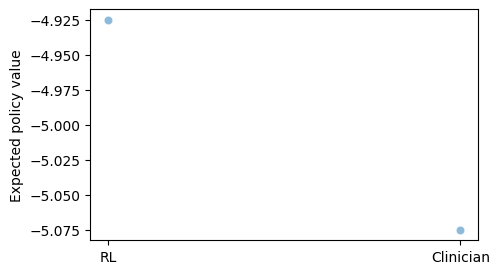

In [ ]:
# Visualization
plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician'], y=[Q_RL, Q_clinician], alpha=0.5)
plt.ylabel('Expected policy value')
plt.show()

/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_26147/3132298367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_RF['action'] = 0
/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_26147/3132298367.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_RF['agent'] = 'RF'
/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_26147/3132298367.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

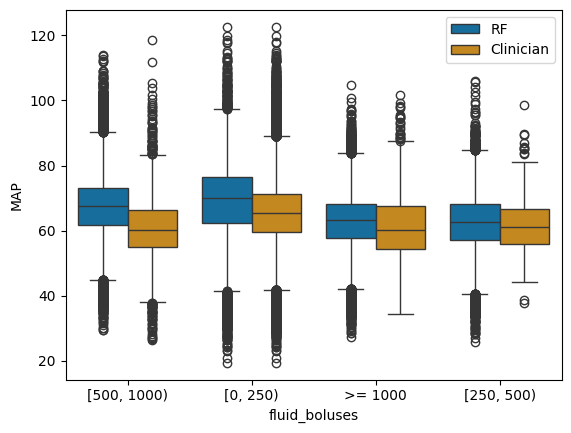

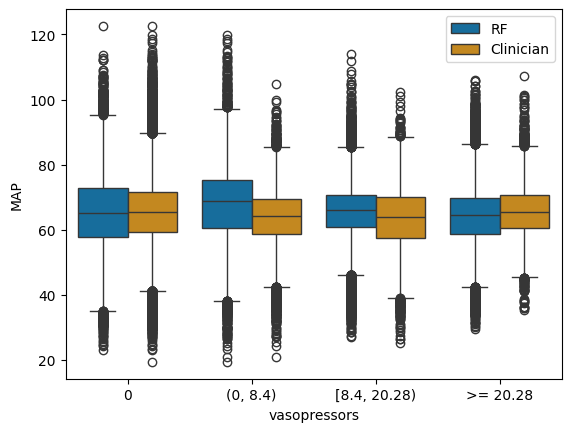

In [ ]:
df_boxplot_RF = df[['MAP']]
df_boxplot_RF['action'] = 0

for index, row in df.iterrows():
    state = torch.FloatTensor(X_canonical[index]).unsqueeze(0).to("mps")  # Get the current state and reshape
    action = torch.LongTensor([int(row['action'])]).to("mps")

    # Use Dueling DQN to get Q-values for the current state
    with torch.no_grad():  # Disable gradient calculation
        q_value = BCQDiscreteAgent.q_network(state)
        max_q_value = torch.max(q_value).item()
        
        # q-value for the actual action taken
        #q_value_action_taken = q_value.gather(1, action.unsqueeze(1)).item()
        #q_values = dueling_dqn(state).cpu().numpy().flatten()

    # Get the action with the maximum Q-value
    df_boxplot_RF.at[index, 'action'] = torch.argmax(q_value).item()
    
df_boxplot_RF['agent'] = 'RF'
df_boxplot_clinician = df[['MAP', 'action']]
df_boxplot_clinician['agent'] = 'Clinician'
df_boxplot = pd.concat([df_boxplot_RF, df_boxplot_clinician], ignore_index=True, sort=False)

fluid_boluses_dict = {
    **dict.fromkeys([0, 1, 2, 3], '[0, 250)'),
    **dict.fromkeys([4, 5, 6, 7], '[250, 500)'),
    **dict.fromkeys([8, 9, 10, 11], '[500, 1000)'),
    **dict.fromkeys([12, 13, 14, 15], '>= 1000')
}
vasopressors_dict = {
    **dict.fromkeys([0, 4, 8, 12], '0'),
    **dict.fromkeys([1, 5, 9, 13], '(0, 8.4)'),
    **dict.fromkeys([2, 6, 10, 14], '[8.4, 20.28)'),
    **dict.fromkeys([3, 7, 11, 15], '>= 20.28')
}
df_boxplot['fluid_boluses'] = df_boxplot['action'].replace(fluid_boluses_dict)
df_boxplot['vasopressors'] = df_boxplot['action'].replace(vasopressors_dict)

sns.boxplot(y='MAP', x='fluid_boluses', data=df_boxplot, palette="colorblind", hue='agent')
plt.legend(loc="upper right")
plt.show()
sns.boxplot(y='MAP', x='vasopressors', data=df_boxplot, palette="colorblind", hue='agent', order=['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28'])
plt.legend(loc="upper right")
plt.show()

---

### Using Conservative Q-Learning from `d3rlpy`

Prepare the dataset:

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQL, CQLConfig, DiscreteCQLConfig, DiscreteCQL

In [3]:
# load data
df = pd.read_csv('Data/C001_FakeHypotension.csv')
print(f'Number of unique patients: {df["PatientID"].nunique()}')

num_patients = df['PatientID'].nunique()

Number of unique patients: 3910


In [4]:
# transform action & assign reward
fluid_boluses_mapping = {v:i for i,v in enumerate(sorted(df['fluid_boluses'].unique()))}
vasopressors_mapping = {v:i for i,v in enumerate(sorted(df['vasopressors'].unique()))}

df['fluid_boluses'] = df['fluid_boluses'].map(fluid_boluses_mapping)
df['vasopressors'] = df['vasopressors'].map(vasopressors_mapping)
df['action_number'] = 4 * df['fluid_boluses'] + df['vasopressors']

def reward_function(row):
    if row.MAP > 65: # 0 at >65
        reward = 0
    elif row.MAP > 60: # -0.05 at 60 and 0 at 65
        reward = -0.05 * (65 - row.MAP) / 5
    elif row.MAP > 55: # -0.15 at 55 and -0.05 at 60
        reward = -0.10 * (60 - row.MAP) / 5 - 0.05
    else: # -1 at 40 and -0.15 at 55
        reward = -0.85 * (55 - row.MAP) / 15 - 0.15
    if row.urine > 30 and row.MAP > 55:
        reward = 0
    return reward

df['reward'] = df.apply(lambda row: reward_function(row), axis=1)
# shift one up so that reward is in the same row of action
df['reward'] = df['reward'].shift(-1)

In [11]:
# scale data
state_columns = ['MAP', 'diastolic_bp', 'systolic_bp', 'urine', 'ALT', 'AST', 'PO2', 'lactic_acid', 'serum_creatinine',
                 'FiO2', 'GCS_total', 'urine_m', 'ALT_AST_m', 'FiO2_m', 'GCS_total_m', 'PO2_m', 'lactic_acid_m', 'serum_creatinine_m']
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[state_columns]), columns=state_columns)
df_scaled["id"] = df["PatientID"]
df_scaled["hour"] = df["Timepoints"]
df_scaled["action"] = df["action_number"]
df_scaled["reward"] = df["reward"]

In [12]:
# convert into numpy arrays
states = []
actions = []
rewards = []
next_states = []
dones = [] 

for idx, row in df_scaled.iterrows():
    if row["hour"] == 47: # terminal state
        done = 1
        next_state = row[state_columns].values # use current state
        reward = 0
    else:
        done = 0
        patient_id = row["id"]
        next_state = df_scaled[(df_scaled["id"]==patient_id) & (df_scaled["hour"]==row["hour"]+1)][state_columns].values[0]
        reward = row["reward"]

    state = row[state_columns].values
    action = row["action"]
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)
    dones.append(done)

states = np.array(states)
actions = np.array(actions)
rewards = np.array(rewards)
next_states = np.array(next_states)
dones = np.array(dones)

In [18]:
# create a dataset for d3rlpy
dataset = {
    "observations": states,
    "actions": actions,
    "rewards": rewards,
    "next_observations": next_states,
    "terminals": dones
}

In [20]:
# create MDP dataset
mdp_dataset = MDPDataset(
    observations=dataset['observations'],
    actions=dataset['actions'],
    rewards=dataset['rewards'],
    terminals=dataset['terminals'],
    #next_observations=dataset['next_observations']
)

2024-10-16 10:49.22 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(18,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2024-10-16 10:49.22 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-10-16 10:49.22 [info     ] Action size has been automatically determined. action_size=16


In [35]:
# initialize CQL algorithm
cql = DiscreteCQLConfig().create(device="mps")
# Train with TensorBoard logging
cql.build_with_dataset(mdp_dataset)

In [36]:
# setup metrics
from d3rlpy.metrics import TDErrorEvaluator, AverageValueEstimationEvaluator, DiscreteActionMatchEvaluator

test_episodes = mdp_dataset.episodes[:30]
cql.fit(
    mdp_dataset, 
    n_steps=100000,
    evaluators={
        "td_error": TDErrorEvaluator(test_episodes),
        "value_scale": AverageValueEstimationEvaluator(test_episodes),
        "action_match": DiscreteActionMatchEvaluator(test_episodes)
    }
)

2024-10-16 11:15.07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(18,)]), action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=16)
2024-10-16 11:15.07 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20241016111507
2024-10-16 11:15.07 [warning  ] Skip building models since they're already built.
2024-10-16 11:15.07 [info     ] Parameters                     params={'observation_shape': [18], 'action_size': 16, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_deca

Epoch 1/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 11:17.08 [info     ] DiscreteCQL_20241016111507: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004304129838943481, 'time_algorithm_update': 0.011463037919998168, 'loss': 0.8992612101107835, 'td_loss': 0.2104194132049568, 'conservative_loss': 0.6888417968943715, 'time_step': 0.011981988620758057, 'td_error': 1.1763489693230198, 'value_scale': 0.2362169657394083, 'action_match': 0.7416666666666667} step=10000
2024-10-16 11:17.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20241016111507/model_10000.d3


Epoch 2/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 11:19.08 [info     ] DiscreteCQL_20241016111507: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.00044329872131347657, 'time_algorithm_update': 0.011357735705375672, 'loss': 0.7838485131070018, 'td_loss': 0.19023093888117001, 'conservative_loss': 0.5936175738126039, 'time_step': 0.011889857292175293, 'td_error': 1.1060213851315348, 'value_scale': 0.23642563699589422, 'action_match': 0.7555555555555555} step=20000
2024-10-16 11:19.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20241016111507/model_20000.d3


Epoch 3/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 11:21.16 [info     ] DiscreteCQL_20241016111507: epoch=3 step=30000 epoch=3 metrics={'time_sample_batch': 0.00047032039165496826, 'time_algorithm_update': 0.012217805337905884, 'loss': 0.7493606949701905, 'td_loss': 0.18317889009099453, 'conservative_loss': 0.5661818047747016, 'time_step': 0.01278356831073761, 'td_error': 1.000608048324187, 'value_scale': 0.36434918164353197, 'action_match': 0.7645833333333333} step=30000
2024-10-16 11:21.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20241016111507/model_30000.d3


Epoch 4/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 11:23.35 [info     ] DiscreteCQL_20241016111507: epoch=4 step=40000 epoch=4 metrics={'time_sample_batch': 0.0005053905248641968, 'time_algorithm_update': 0.013123692750930786, 'loss': 0.7296902818918228, 'td_loss': 0.180056304978393, 'conservative_loss': 0.5496339763984084, 'time_step': 0.013728505921363831, 'td_error': 1.0275055687654844, 'value_scale': 0.39041954687434355, 'action_match': 0.7625} step=40000
2024-10-16 11:23.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20241016111507/model_40000.d3


Epoch 5/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 11:25.45 [info     ] DiscreteCQL_20241016111507: epoch=5 step=50000 epoch=5 metrics={'time_sample_batch': 0.00046287987232208254, 'time_algorithm_update': 0.012365270066261291, 'loss': 0.7098156962394714, 'td_loss': 0.1762034255272709, 'conservative_loss': 0.5336122708261013, 'time_step': 0.012919003200531005, 'td_error': 0.9100785998040288, 'value_scale': 0.4837847098423582, 'action_match': 0.76875} step=50000
2024-10-16 11:25.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20241016111507/model_50000.d3


Epoch 6/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 11:27.45 [info     ] DiscreteCQL_20241016111507: epoch=6 step=60000 epoch=6 metrics={'time_sample_batch': 0.00043772783279418946, 'time_algorithm_update': 0.01141563696861267, 'loss': 0.6934653467684985, 'td_loss': 0.1733064783487469, 'conservative_loss': 0.52015886823982, 'time_step': 0.011943430042266846, 'td_error': 0.902791249494401, 'value_scale': 0.5038627842596421, 'action_match': 0.7770833333333333} step=60000
2024-10-16 11:27.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20241016111507/model_60000.d3


Epoch 7/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 11:29.48 [info     ] DiscreteCQL_20241016111507: epoch=7 step=70000 epoch=7 metrics={'time_sample_batch': 0.0004486071825027466, 'time_algorithm_update': 0.011650555610656739, 'loss': 0.6815635193631053, 'td_loss': 0.17175397233413534, 'conservative_loss': 0.5098095473885537, 'time_step': 0.012192295718193054, 'td_error': 0.9182018902838621, 'value_scale': 0.5592006114596088, 'action_match': 0.775} step=70000
2024-10-16 11:29.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20241016111507/model_70000.d3


Epoch 8/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 11:31.45 [info     ] DiscreteCQL_20241016111507: epoch=8 step=80000 epoch=8 metrics={'time_sample_batch': 0.000422174596786499, 'time_algorithm_update': 0.011122186160087585, 'loss': 0.6724498031288385, 'td_loss': 0.16921300405235962, 'conservative_loss': 0.5032367989465595, 'time_step': 0.011632169914245606, 'td_error': 0.8949107264620799, 'value_scale': 0.5482386126286454, 'action_match': 0.7763888888888889} step=80000
2024-10-16 11:31.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20241016111507/model_80000.d3


Epoch 9/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 11:33.40 [info     ] DiscreteCQL_20241016111507: epoch=9 step=90000 epoch=9 metrics={'time_sample_batch': 0.00041709463596343997, 'time_algorithm_update': 0.010966786646842957, 'loss': 0.6652459427177906, 'td_loss': 0.17006940407399088, 'conservative_loss': 0.4951765385776758, 'time_step': 0.011469808077812196, 'td_error': 0.8935112516728693, 'value_scale': 0.5982772668202718, 'action_match': 0.7833333333333333} step=90000
2024-10-16 11:33.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20241016111507/model_90000.d3


Epoch 10/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 11:35.36 [info     ] DiscreteCQL_20241016111507: epoch=10 step=100000 epoch=10 metrics={'time_sample_batch': 0.0004163735866546631, 'time_algorithm_update': 0.01096441946029663, 'loss': 0.6577849267974496, 'td_loss': 0.16929875969346614, 'conservative_loss': 0.4884861671432853, 'time_step': 0.01146746814250946, 'td_error': 0.8043354569774865, 'value_scale': 0.6513829296066737, 'action_match': 0.7798611111111111} step=100000
2024-10-16 11:35.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20241016111507/model_100000.d3


[(1,
  {'time_sample_batch': 0.0004304129838943481,
   'time_algorithm_update': 0.011463037919998168,
   'loss': 0.8992612101107835,
   'td_loss': 0.2104194132049568,
   'conservative_loss': 0.6888417968943715,
   'time_step': 0.011981988620758057,
   'td_error': 1.1763489693230198,
   'value_scale': 0.2362169657394083,
   'action_match': 0.7416666666666667}),
 (2,
  {'time_sample_batch': 0.00044329872131347657,
   'time_algorithm_update': 0.011357735705375672,
   'loss': 0.7838485131070018,
   'td_loss': 0.19023093888117001,
   'conservative_loss': 0.5936175738126039,
   'time_step': 0.011889857292175293,
   'td_error': 1.1060213851315348,
   'value_scale': 0.23642563699589422,
   'action_match': 0.7555555555555555}),
 (3,
  {'time_sample_batch': 0.00047032039165496826,
   'time_algorithm_update': 0.012217805337905884,
   'loss': 0.7493606949701905,
   'td_loss': 0.18317889009099453,
   'conservative_loss': 0.5661818047747016,
   'time_step': 0.01278356831073761,
   'td_error': 1.0006

Off-policy evaluation

In [37]:
# save model
cql.save('cql.d3')
cql.save_policy('cql_policy.pt')

In [40]:
import d3rlpy

# off-policy evaluation
fqe = d3rlpy.ope.DiscreteFQE(algo=cql, config=d3rlpy.ope.FQEConfig(), device="mps")
# train estimators to evaluate the trained policy
fqe.fit(
    mdp_dataset,
    n_steps=100000,
    evaluators={
        "init_value": d3rlpy.metrics.InitialStateValueEstimationEvaluator(),
        "soft_opc": d3rlpy.metrics.SoftOPCEvaluator(return_threshold=-300)
    }
)

2024-10-16 12:22.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(18,)]), action_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=16)
2024-10-16 12:22.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20241016122219
2024-10-16 12:22.19 [debug    ] Building models...            
2024-10-16 12:22.19 [debug    ] Models have been built.       
2024-10-16 12:22.19 [info     ] Parameters                     params={'observation_shape': [18], 'action_size': 16, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 0.0001, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 

Epoch 1/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 12:24.18 [info     ] DiscreteFQE_20241016122219: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0011309924840927125, 'time_algorithm_update': 0.008619466829299927, 'loss': 0.043707456385949625, 'time_step': 0.009804734325408935, 'init_value': -2.1786532402038574, 'soft_opc': 0.0} step=10000
2024-10-16 12:24.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20241016122219/model_10000.d3


Epoch 2/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 12:26.16 [info     ] DiscreteFQE_20241016122219: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.001139180541038513, 'time_algorithm_update': 0.008684931111335755, 'loss': 0.06834733715066686, 'time_step': 0.009879460310935975, 'init_value': -2.7498340606689453, 'soft_opc': 0.0} step=20000
2024-10-16 12:26.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20241016122219/model_20000.d3


Epoch 3/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 12:28.12 [info     ] DiscreteFQE_20241016122219: epoch=3 step=30000 epoch=3 metrics={'time_sample_batch': 0.001115542149543762, 'time_algorithm_update': 0.008481657576560974, 'loss': 0.07215766334347427, 'time_step': 0.009650930404663086, 'init_value': -2.7719571590423584, 'soft_opc': 0.0} step=30000
2024-10-16 12:28.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20241016122219/model_30000.d3


Epoch 4/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 12:30.06 [info     ] DiscreteFQE_20241016122219: epoch=4 step=40000 epoch=4 metrics={'time_sample_batch': 0.0011231043100357056, 'time_algorithm_update': 0.008459568428993225, 'loss': 0.072302508245036, 'time_step': 0.009636115455627441, 'init_value': -2.7191162109375, 'soft_opc': 0.0} step=40000
2024-10-16 12:30.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20241016122219/model_40000.d3


Epoch 5/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 12:32.04 [info     ] DiscreteFQE_20241016122219: epoch=5 step=50000 epoch=5 metrics={'time_sample_batch': 0.0011342490673065186, 'time_algorithm_update': 0.008645544576644898, 'loss': 0.07470620042486116, 'time_step': 0.009835943150520325, 'init_value': -2.7874984741210938, 'soft_opc': 0.0} step=50000
2024-10-16 12:32.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20241016122219/model_50000.d3


Epoch 6/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 12:33.59 [info     ] DiscreteFQE_20241016122219: epoch=6 step=60000 epoch=6 metrics={'time_sample_batch': 0.0011206692218780517, 'time_algorithm_update': 0.008450587224960327, 'loss': 0.07509064251277596, 'time_step': 0.009624484848976135, 'init_value': -2.5606935024261475, 'soft_opc': 0.0} step=60000
2024-10-16 12:33.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20241016122219/model_60000.d3


Epoch 7/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 12:35.55 [info     ] DiscreteFQE_20241016122219: epoch=7 step=70000 epoch=7 metrics={'time_sample_batch': 0.0011290849447250365, 'time_algorithm_update': 0.00859702341556549, 'loss': 0.07286140357749536, 'time_step': 0.009780665850639343, 'init_value': -2.648571014404297, 'soft_opc': 0.0} step=70000
2024-10-16 12:35.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20241016122219/model_70000.d3


Epoch 8/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 12:37.53 [info     ] DiscreteFQE_20241016122219: epoch=8 step=80000 epoch=8 metrics={'time_sample_batch': 0.0011306103706359863, 'time_algorithm_update': 0.00864562771320343, 'loss': 0.07632099412949755, 'time_step': 0.009831726384162904, 'init_value': -2.7725021839141846, 'soft_opc': 0.0} step=80000
2024-10-16 12:37.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20241016122219/model_80000.d3


Epoch 9/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 12:39.50 [info     ] DiscreteFQE_20241016122219: epoch=9 step=90000 epoch=9 metrics={'time_sample_batch': 0.0011405635595321654, 'time_algorithm_update': 0.008534447956085205, 'loss': 0.07946698361616582, 'time_step': 0.009729569458961487, 'init_value': -2.9010305404663086, 'soft_opc': 0.0} step=90000
2024-10-16 12:39.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20241016122219/model_90000.d3


Epoch 10/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-10-16 12:41.46 [info     ] DiscreteFQE_20241016122219: epoch=10 step=100000 epoch=10 metrics={'time_sample_batch': 0.0011315298318862914, 'time_algorithm_update': 0.00851585087776184, 'loss': 0.0771066483784467, 'time_step': 0.009702664422988892, 'init_value': -2.6180930137634277, 'soft_opc': 0.0} step=100000
2024-10-16 12:41.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20241016122219/model_100000.d3


[(1,
  {'time_sample_batch': 0.0011309924840927125,
   'time_algorithm_update': 0.008619466829299927,
   'loss': 0.043707456385949625,
   'time_step': 0.009804734325408935,
   'init_value': -2.1786532402038574,
   'soft_opc': 0.0}),
 (2,
  {'time_sample_batch': 0.001139180541038513,
   'time_algorithm_update': 0.008684931111335755,
   'loss': 0.06834733715066686,
   'time_step': 0.009879460310935975,
   'init_value': -2.7498340606689453,
   'soft_opc': 0.0}),
 (3,
  {'time_sample_batch': 0.001115542149543762,
   'time_algorithm_update': 0.008481657576560974,
   'loss': 0.07215766334347427,
   'time_step': 0.009650930404663086,
   'init_value': -2.7719571590423584,
   'soft_opc': 0.0}),
 (4,
  {'time_sample_batch': 0.0011231043100357056,
   'time_algorithm_update': 0.008459568428993225,
   'loss': 0.072302508245036,
   'time_step': 0.009636115455627441,
   'init_value': -2.7191162109375,
   'soft_opc': 0.0}),
 (5,
  {'time_sample_batch': 0.0011342490673065186,
   'time_algorithm_update'

In [9]:
df_scaled

,MAP,diastolic_bp,systolic_bp,urine,ALT,AST,PO2,lactic_acid,serum_creatinine,FiO2,...,ALT_AST_m,FiO2_m,GCS_total_m,PO2_m,lactic_acid_m,serum_creatinine_m,id,hour,action,reward
0,0.291491,0.231564,2.282659,0.996920,-0.624015,-0.852425,-0.973460,-0.258458,-0.588325,2.578920,...,-0.123466,-0.284868,2.098009,-0.158299,-0.176516,-0.223013,0,0,0,0.00000
1,-0.175881,-0.095697,2.190196,0.898527,-0.636239,-0.698626,0.724674,0.297012,-0.632283,2.578920,...,-0.123466,-0.284868,-0.476642,-0.158299,-0.176516,-0.223013,0,1,0,0.00000
2,0.054211,0.252327,2.208066,0.778767,-0.725052,-0.791953,-0.940888,-0.480105,-0.695399,2.578920,...,-0.123466,-0.284868,-0.476642,-0.158299,-0.176516,-0.223013,0,2,0,-0.73454
3,-2.203230,-1.339380,0.329910,1.474898,-0.232511,-0.844583,-0.095901,-0.745962,-0.790219,2.578920,...,-0.123466,-0.284868,-0.476642,-0.158299,-0.176516,-0.223013,0,3,0,0.00000
4,-0.402766,1.003491,-0.077144,2.820992,0.259349,-0.867365,-1.889817,0.540280,-0.207249,2.578920,...,-0.123466,-0.284868,2.098009,-0.158299,-0.176516,-0.223013,0,4,0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187675,-0.657695,-0.981163,-0.612802,-0.667850,-0.360112,-0.493525,1.306375,-0.441626,-0.654468,2.578920,...,-0.123466,-0.284868,-0.476642,-0.158299,-0.176516,-0.223013,3909,43,0,0.00000
187676,1.458602,1.099831,0.758750,-0.473697,-0.622673,-0.622270,0.998245,-0.882958,-0.528751,-0.882027,...,-0.123466,-0.284868,-0.476642,-0.158299,-0.176516,-0.223013,3909,44,0,0.00000
187677,0.958055,0.371956,0.811104,-0.676757,-0.761094,-0.560746,0.244640,-0.463542,-0.306942,-0.882027,...,-0.123466,-0.284868,-0.476642,-0.158299,-0.176516,-0.223013,3909,45,0,0.00000
187678,2.529976,1.639894,0.911859,-0.558419,-0.721142,-0.590485,0.171965,-0.672069,-0.479844,-0.882027,...,-0.123466,-0.284868,-0.476642,-0.158299,-0.176516,-0.223013,3909,46,0,0.00000
